In [1]:
from qacits import calibrate_qacits, run_qacits
import os
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 1/ Load demo data

In [2]:
os.chdir(os.path.normpath(os.path.expandvars('$HOME/QACITS')))
psf_OFF = fits.getdata('data/offaxis_PSF_L_CVC.fits')
psf_ON_calib = fits.getdata('data/onaxis_PSF_L_CVC_calib.fits.gz')
psf_ON_jitter = fits.getdata('data/onaxis_PSF_L_CVC_jitter.fits.gz')
tt_lamD_calib = fits.getdata('data/point_8s_100ms_L_calib.fits')
tt_lamD_jitter = fits.getdata('data/point_8s_100ms_L_jitter.fits')
img_sampling = 3.98 # pix per lambda/D
lamD = 21.78 # mas per lambda/D
dit = 0.1 # seconds

In [3]:
logb = .02
npts = 40
xy = np.logspace(np.log10(logb), np.log10(.5 + logb), npts) - logb
tt = np.array([(x,0) for x in xy] + [(0,y) for y in xy])
fits.writeto('data/point_24s_100ms_L_calib.fits', tt, overwrite=True)

### 2/ QACITS default parameters

In [4]:
qacits_params = dict(
    force = None,
    coeffs = {'inner':1, 'outer':1, 'full':1},
    radii = {'inner':(0,1.7), 'outer':(1.7,2.3), 'full':(0, 2.7)},
    nbin = 0,
    ratio = 0,
    phase_tolerance = 60,
    modul_tolerance = 0.33,
    small_tt_regime = 0.3,
    large_tt_regime = 0.2, 
)

### 3/ Calibrate QACITS with known tip-tilt

psf_flux = 0.26036 (photutils is True)

Model calibration results:
Inner slope = 0.218
Outer slope = 0.121
Full coeff  = 1.373


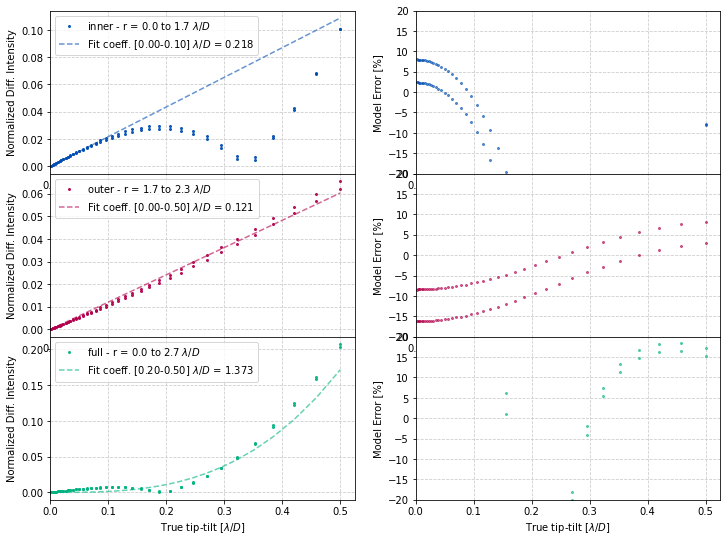

In [5]:
qacits_params['coeffs'] = calibrate_qacits(psf_ON_calib, psf_OFF, img_sampling, tt_lamD_calib, plot_fig=True, verbose=True)
qacits_params['force'] = 'outer'

### 4/ Run QACITS: pointing error estimation

In [6]:
tiptilt_estimate = run_qacits(psf_ON_jitter, psf_OFF, img_sampling, **qacits_params)

### 5/ Figure: residuals

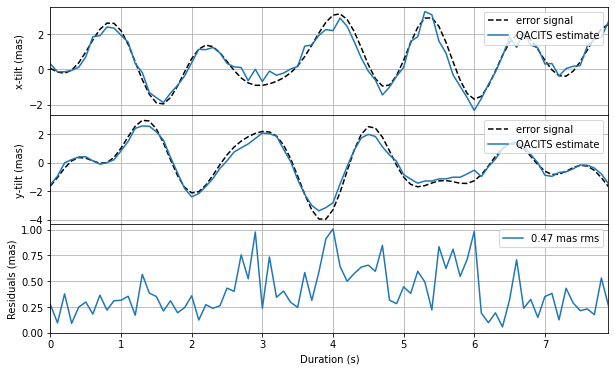

In [7]:
# convert to mas
tt_est = -tiptilt_estimate[:,0:2]*lamD
tt_true = tt_lamD_jitter*lamD
# rms error
dist = np.sqrt((tt_est[:,0]-tt_true[:,0])**2 + (tt_est[:,1]-tt_true[:,1])**2)
rms = np.sqrt(np.mean(dist**2))
# figure
ts = dit*np.arange(len(tt_lamD_jitter))
fig, (a0, a1, a2) = plt.subplots(3, 1, figsize=(10,6), sharex=True)
fig.subplots_adjust(hspace=0)
a0.plot(ts, tt_true[:,0], label='error signal', color='k', linestyle='--')
a0.plot(ts, tt_est[:,0], label='QACITS estimate')
a0.set_ylabel('x-tilt (mas)')
a0.legend(loc='upper right'); a0.grid(True)
a0.set_xlim((0, ts[-1]))
a1.plot(ts, tt_true[:,1], label='error signal', color='k', linestyle='--')
a1.plot(ts, tt_est[:,1], label='QACITS estimate')
a1.set_ylabel('y-tilt (mas)')
a1.legend(loc='upper right'); a1.grid(True)
a1.set_xlim((0, ts[-1]))
a2.plot(ts, dist, label='%.2f mas rms'%rms)
a2.set_xlabel('Duration (s)')
a2.set_ylabel('Residuals (mas)')
a2.legend(loc='upper right'); a2.grid(True)
a2.set_xlim((0, ts[-1]))
a2.set_ylim(bottom=0);